In [3]:
import numpy as np
import glob

import pandas as pd


def load_interim_samples(path):
    file_list = glob.glob(path + "/*")
    file_list.sort()
    data_unlabeled = []
    for f in file_list:
        interim_data = np.loadtxt(f, delimiter=',', skiprows=1)
        data_unlabeled.append(interim_data)

    return data_unlabeled

In [4]:
data_unlabeled = load_interim_samples("../data/interim/unlabeled")
data_labeled = load_interim_samples("../data/interim/labeled")

I expect unlabeled samples to be a linear combination of labeled samples (more materials can be in one acquisition).
Thus, I am exploring the linear combinations of the labeled samples with positive coefficients
that return the same spectrogram.
In that case, the coeff with account for the abbundance of the material.

In [9]:
from scipy.interpolate import interp1d


def interpolate_signals(data):
    """
    Interpolates signals to enable comparison
    """
    interp_rage = np.arange(0, 2400)
    samples = np.ndarray(shape=(2400, len(data)))
    for i, spec in enumerate(data):
        fit = interp1d(spec[:, 0], spec[:, 1], fill_value="extrapolate")
        samples[:, i] = fit(interp_rage)

    return samples

In [12]:
samples_labeled = interpolate_signals(data_labeled)
samples_unlabeled = interpolate_signals(data_unlabeled)

samples_labeled.shape, samples_unlabeled.shape

((2400, 61), (2400, 242))

In [34]:
from sklearn.linear_model import LinearRegression
import pandas as pd


def infer_materials(index):
    model = LinearRegression(positive=True).fit(samples_labeled, samples_unlabeled[:, index])

    glob_label = glob.glob("../data/interim/labeled/*")
    glob_label.sort()
    materials_label = [k.split('/')[-1].split('.')[0] for k in glob_label]

    quant = pd.DataFrame({
        "label": materials_label,
        "value": model.coef_
    })

    return quant

<AxesSubplot:>

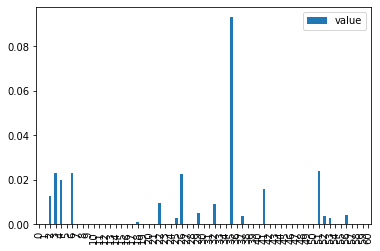

In [38]:
y_pred = infer_materials(0)

y_pred.plot(kind='bar')